# Анализ бизнес-показателей

<a name="1common."></a>
## <a name="0.0"></a>Содержание:
* [Подгрузка библиотек и самописные функции](#0.)
* [Загрузка данных](#01.)
* [Рассчет бизнес метрик](#1.)
    * [Продуктовые метрики](#11.)
    * [Метрики электронной коммерции](#12.)
    * [Маркетинговые метрики](#12.)
* [Выводы и рекомендации](#3.)

## Описание проекта
Вас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. 
Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

#### Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* 		лог сервера с данными о посещениях сайта Яндекс.Афиши,
* 		выгрузка всех заказов за этот период,
* 		статистика рекламных расходов.

#### Вам предстоит изучить:
* 		как клиенты пользуются сервисом,
* 		когда делают первые покупки на сайте,
* 		сколько денег приносит компании каждый клиент,
* 		когда расходы на привлечение клиента окупаются.

#### Выручка измеряется в условных единицах — у.е.

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера</b>

Отличное начало!
</div>

## Подгрузка библиотек и самописные функции
<a name="0."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [1]:
# обновим до последней версии
!pip install seaborn --upgrade

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.2)


In [2]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера</b>

Импорт библиотек сразу настраивает рабочую среду,супер!
</div>

In [3]:
#Определяем болд
def bold(): 
    return "\033[1m"

def bold_end(): 
    return "\033[0m"

#Ставим формат для нумериков
pd.options.display.float_format = '{: >10.2f}'.format

In [4]:
#**Функция print_basic_info, для вывода информации о массиве, и его переменных.**

#* base - название базы данных
#* info - 1: вывод информации о массиве, другое: не вывод
#* describe - 1: вывод описания переменных массива, другое: не вывод        
#* duplicat - 1: вывод количества полных дублей
#* head - n: вывод примера базы (вывод n - строк), n < 1: не вывод

def print_basic_info(base, info, describe, duplicat, head_tail):
    if info == 1:
        print("\n", bold(), colored('info','green'), bold_end(), "\n")
        print( base.info())  
    if head_tail >= 1:
        print("\n", bold(),colored('head_tail','green'),bold_end())
        display(base.head(head_tail).append(base.tail(head_tail)))
    if describe == 1:
        print("\n", bold(),colored('describe','green'),bold_end(),"\n")
        for i in base.columns:
            print("\n", bold(), colored(i,'blue'),bold_end(),"\n", base[i].describe())
    if duplicat == 1:
        print("\n", bold(),colored('duplicated','green'),bold_end(),"\n")
        print(base[base.duplicated() == True][base.columns[0]].count())

## Загрузка данных
<a name="01."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [5]:
#загрузим

try:
    visits = pd.read_csv('/datasets/visits_log.csv', sep=',',decimal='.', parse_dates= ['End Ts','Start Ts'])
    orders = pd.read_csv('/datasets/orders_log.csv', sep=',',decimal='.', parse_dates= ['Buy Ts'])
    expenses = pd.read_csv('/datasets/costs.csv', sep=',',decimal='.', parse_dates = ['dt'])
except:
    visits = pd.read_csv('datasets/visits_log.csv', sep=',',decimal='.', parse_dates= ['End Ts', 'Start Ts'])
    orders = pd.read_csv('datasets/orders_log.csv', sep=',',decimal='.',parse_dates= ['Buy Ts'])
    expenses = pd.read_csv('datasets/costs.csv', sep=',',decimal='.', parse_dates = ['dt'])

* Всего 359400. Пропусков нет.
* Полных дублей нет.
* Уникальных ключей всего 228169. Значит было несколько визитов.

'Start Ts' и 'End Ts' - Даты, сразу обозначим это при окрытиии файла.

In [6]:
#данные о визитах;
print_basic_info(visits,1,1,1,4)

#уникальных ключей
print("\n", bold(),colored('unique keys','green'),bold_end(),"\n")
len(visits['Uid'].unique())


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null datetime64[ns]
Source Id    359400 non-null int64
Start Ts     359400 non-null datetime64[ns]
Uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
None

  head_tail 


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485
359399,touch,2017-09-10 13:13:19,2,2017-09-10 13:13:00,18396128934054549559



  describe  


  Device  
 count      359400
unique          2
top       desktop
freq       262567
Name: Device, dtype: object

  End Ts  
 count                  359400
unique                 224760
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: End Ts, dtype: object

  Source Id  
 count    359400.00
mean          3.75
std           1.92
min           1.00
25%           3.00
50%           4.00
75%           5.00
max          10.00
Name: Source Id, dtype: float64

  Start Ts  
 count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: Start Ts, dtype: object

  Uid  
 count                 359400.00
mean     9202556994354921472.00
std      5298432824659611648.00
min           11863502262781.00
25%      4613406732167550976.00
50%      9227412908740601856.00
75%     1372823701123617

228169

* Всего 359400. Пропусков нет.
* Полных дублей нет.
* Уникальных ключей всего 228169. Значит было несколько визитов.

'Start Ts' и 'End Ts' - Даты, сразу обозначим это при окрытиии файла.

In [7]:
#данные о заказы;
print_basic_info(orders,1,1,1,4)

#уникальных ключей
print("\n", bold(), colored('unique keys','green'),bold_end(),"\n")
len(orders['Uid'].unique())


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null datetime64[ns]
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None

  head_tail 


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247
50414,2018-06-01 00:02:00,3.42,83872787173869366



  describe  


  Buy Ts  
 count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: Buy Ts, dtype: object

  Revenue  
 count     50415.00
mean          5.00
std          21.82
min           0.00
25%           1.22
50%           2.50
75%           4.89
max        2633.28
Name: Revenue, dtype: float64

  Uid  
 count                  50415.00
mean     9098160634289729536.00
std      5285741550834715648.00
min          313578113262317.00
25%      4533566627250599936.00
50%      9102273602618561536.00
75%     13682901980465401856.00
max     18446167067214817280.00
Name: Uid, dtype: float64

  duplicated  

0

  unique keys  



36523

* Полных дублей нет.
* Всего 50415.00. Пропусков нет.
* Уникальных ключей всего 36523. Значит могло быть несколько заказов от одного айди.

'Buy Ts' - Даты, сразу обозначим это при окрытии файла.

In [8]:
#данные о expenses
print_basic_info(expenses,1,1,1,4)


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB
None

  head_tail 


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15
2541,10,2018-05-31,17.60



  describe  


  source_id  
 count      2542.00
mean          4.86
std           3.18
min           1.00
25%           2.00
50%           4.00
75%           9.00
max          10.00
Name: source_id, dtype: float64

  dt  
 count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

  costs  
 count      2542.00
mean        129.48
std         156.30
min           0.54
25%          21.95
50%          77.30
75%         170.06
max        1788.28
Name: costs, dtype: float64

  duplicated  

0


<!-- # data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
# data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
# data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
# data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
# data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
# data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
# data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv') -->

* Всего 2542. Пропусков нет.
* Полных дублей нет.

'dt' - Даты, сразу обозначим это при окрытиии файла.

In [9]:
# приведем колонки к виду нижжние кейсы и '_' вместо пробелов для болеее удобного использования далее

In [10]:
visits.columns = map(str.lower, visits.columns)
visits.columns = visits.columns.str.replace(" ", "_")
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [11]:
orders.columns = map(str.lower, orders.columns)
orders.columns = orders.columns.str.replace(" ", "_")
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [12]:
expenses.columns = map(str.lower, expenses.columns)
expenses.columns = expenses.columns.str.replace(" ", "_")
expenses.columns

Index(['source_id', 'dt', 'costs'], dtype='object')

In [13]:
#таблицы для ревьюера

visits_copy = visits.copy()
orders_copy = orders.copy()
expenses_copy = expenses.copy()

## Рассчет бизнес метрик
<a name="1."></a>
[<font size="2">(к содержанию)</font>](#1common.)

Посчитайте метрики трёх видов:
* 		продуктовые,
* 		метрики электронной коммерции,
* 		маркетинговые.


### Продуктовые метрики
<a name="11."></a>
[<font size="2">(к содержанию)</font>](#1common.)

#### DAU, WAU и MAU

In [14]:
# определим временные промежутки
visits['week'] = visits['start_ts'].astype('datetime64[W]') 
visits['month'] = visits['start_ts'].astype('datetime64[M]') 
visits['day'] = visits['start_ts'].astype('datetime64[D]') 

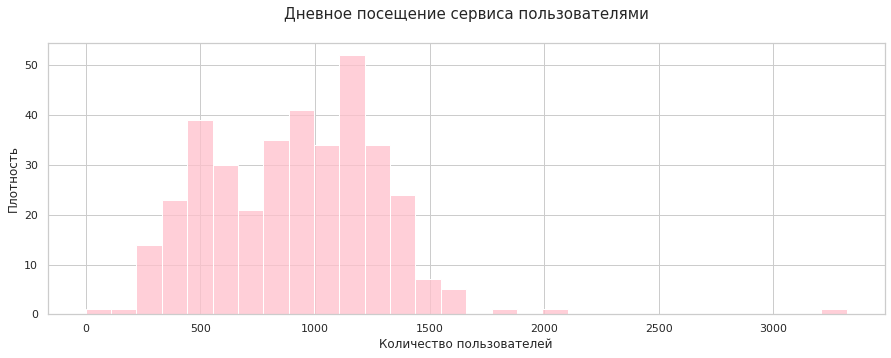

In [15]:
data = visits.groupby(['day']).agg({'uid': 'nunique'}).reset_index()
#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (15,5)) 
sns.histplot(x="uid", bins=30 ,data=data,
            label="Total" , color="pink")
plt.title("Дневное посещение сервиса пользователями\n", fontsize=15)
plt.ylabel("Плотность")
plt.xlabel("Количество пользователей")
plt.show()

In [16]:
dau = visits.groupby(['day']).agg({'uid': 'nunique'}).mean()
print("dau: ",round(dau.values[0],0))

dau:  908.0


В среднем в день сервис посещают 908 пользователей. В большинство дней  посещения колеблется приблизительно от  400 до 1300 человек.

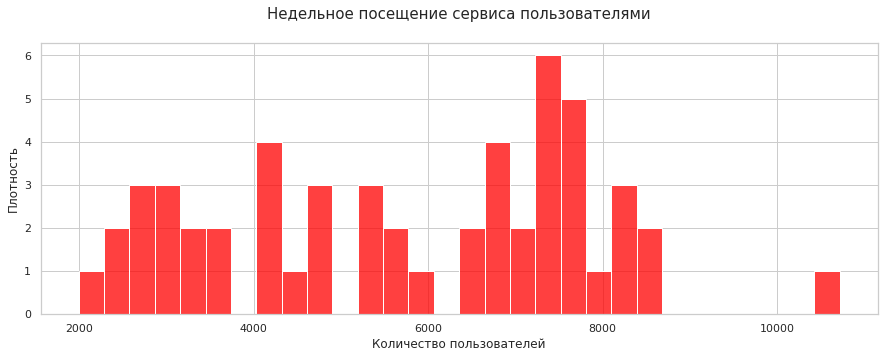

In [17]:
data = visits.groupby(['week']).agg({'uid': 'nunique'}).reset_index()
#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (15,5)) 
sns.histplot(x="uid", bins=30 ,data=data,
            label="Total" , color="red")
plt.title("Недельное посещение сервиса пользователями\n", fontsize=15)
plt.ylabel("Плотность")
plt.xlabel("Количество пользователей")
plt.show()

In [18]:
wau = visits.groupby(['week']).agg({'uid': 'nunique'}).mean()
print("wau: ",round(wau.values[0],0))

wau:  5724.0


В среднем в неделю сервис посещают 5724 пользователей. Поведение пользователей не консистентное. Наблюдается разделение на 3 кластера.
Как гипотеза это может быть связанно с годовой сезонностью или же сезонностью внутри месяца. Проверим построив barplot график 

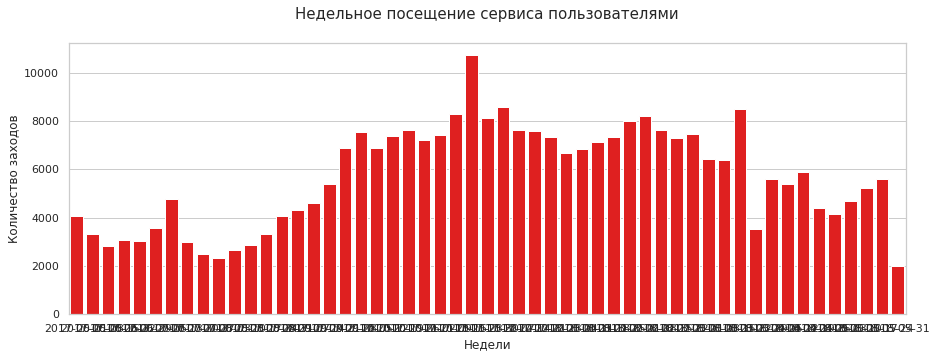

In [19]:
data = visits.groupby(['week']).agg({'uid': 'nunique'}).reset_index()
data['week'] = data['week'].astype('str')
#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (15,5)) 
sns.barplot(y="uid", x="week", data=data,
            label="Total" , color="red")
plt.title("Недельное посещение сервиса пользователями\n", fontsize=15)
plt.xlabel("Недели")
plt.ylabel("Количество заходов")
plt.show()

Прослежевается годовая сезонность

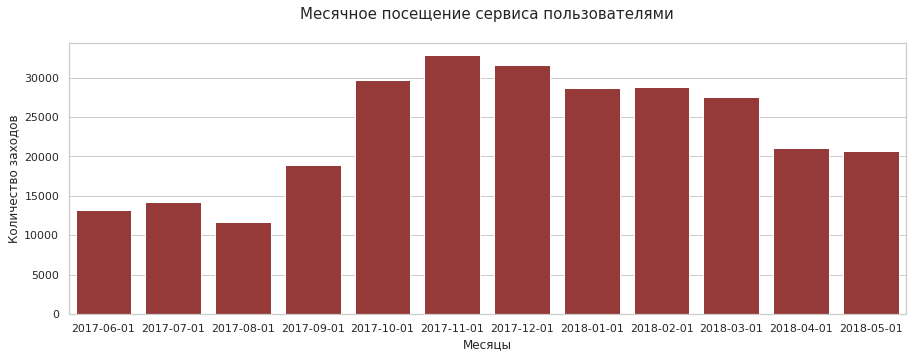

In [20]:
data = visits.groupby(['month']).agg({'uid': 'nunique'}).reset_index()
data['month'] = data['month'].astype('str')
#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (15,5)) 
sns.barplot(y="uid", x="month", data=data,
            label="Total" , color="brown")
plt.title("Месячное посещение сервиса пользователями\n", fontsize=15)
plt.xlabel("Месяцы")
plt.ylabel("Количество заходов")
plt.show()

In [21]:
mau = visits.groupby(['month']).agg({'uid': 'nunique'}).mean()
print("mau: ",round(mau.values[0],0))

mau:  23228.0


В среднем в месяц сервис посещают 23228 пользователей. Больше посетителей приходится на зимний период.

#### Cколько раз за день пользователи в среднем заходят на сайт

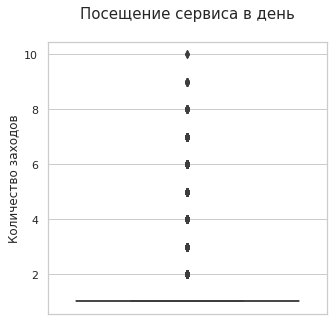

In [22]:
data = visits.groupby(['day','uid']).agg({'month': 'count'}).reset_index()
#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (5,5)) 
sns.boxplot(y="month", orient="v", data=data, color="brown")
plt.title("Посещение сервиса в день\n", fontsize=15)

plt.ylabel("Количество заходов")
plt.show()

In [23]:
 round(visits.groupby(['day','uid']).agg({'uid': 'count'}).mean().values[0],2)

1.09

Подавляющее большинство заходят на сервис всего 1 раз в день.

#### Исследуйте, сколько времени пользователи проводят на сайте. 

Узнайте продолжительность типичной пользовательской сессии за весь период. Чтобы выбрать подходящую среднюю меру, постройте график распределения.

In [24]:
visits['time_session'] = (visits['end_ts'] - visits['start_ts']) / np.timedelta64(1, 'm')

In [25]:
visits['time_session'].describe()

count    359400.00
mean         10.72
std          16.62
min         -46.00
25%           2.00
50%           5.00
75%          14.00
max         711.00
Name: time_session, dtype: float64

min: -46.0 max: 711.0


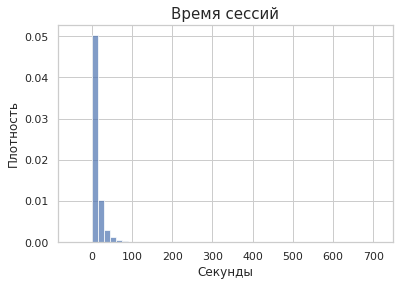

In [26]:
visits['time_session'].hist(bins = 50, alpha=0.7, label = "str(i)",  density=True)
print("min:", min(visits['time_session']),"max:", max(visits['time_session']) )
plt.title("Время сессий", fontsize=15)
plt.xlabel("Секунды")
plt.ylabel("Плотность")
plt.show()

**Часть данных меньше и равна 0 секунд, есть сильный выброс в большую сторону тоже**

Возможно информация не подгрузилась корректно, необходимо уточнить этот момент у программистов.

**А пока выкинем все меньше нуля, а также больше сильно большие выбросы и 
так как длинна сессии распределена неравномерно будем смотреть моду**

In [27]:
#меньше 0
visits[(visits['time_session'] < 0)]

,device,end_ts,source_id,start_ts,uid,week,month,day,time_session
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018-03-22,2018-03-01,2018-03-25,-32.00
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018-03-22,2018-03-01,2018-03-25,-46.00


In [28]:
#выбивающееся большое время
visits[(visits['time_session'] > max(visits['time_session']) - (np.std(visits['time_session'])*3))]

,device,end_ts,source_id,start_ts,uid,week,month,day,time_session
229891,desktop,2017-12-18 22:43:00,3,2017-12-18 10:52:00,15566184277200431914,2017-12-14,2017-12-01,2017-12-18,711.00


In [29]:
mode_visits = visits[(visits['time_session'] > 0)]
mode_visits = mode_visits[(mode_visits['time_session'] <  max(mode_visits['time_session'])
                           - (np.std(mode_visits['time_session'])*3))]

In [30]:
print("Наиболее частое время сессии", mode_visits['time_session'].mode().values[0], "минута")

print("Медианное время сессии", mode_visits['time_session'].median(), "минут")

Наиболее частое время сессии 1.0 минута
Медианное время сессии 6.0 минут


#### Рассчитайте Retention Rate, применяя когортный анализ. Найдите средний Retention Rate на второй месяц «жизни» когорт.

In [31]:
first_activity_date = visits.groupby(['uid'])['month'].min()
first_activity_date.name = 'first_activity_month'
visits2 = visits.join(first_activity_date,on='uid')

In [32]:
visits2['cohort_lifetime'] = visits2['month'] - visits2['first_activity_month']
visits2['cohort_lifetime'] = (visits2['cohort_lifetime']/np.timedelta64(1,'M')).astype(int)

cohorts = visits2.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 

initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

cohorts = cohorts.merge(initial_users_count,on='first_activity_month') 
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users'] 

In [33]:
users_pivot = cohorts.pivot_table(index='first_activity_month',
                                      columns='cohort_lifetime', values='uid', aggfunc='sum')


In [34]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',
                                      columns='cohort_lifetime',values='retention',aggfunc='sum') 

In [35]:
print("Средний Retention Rate на второй месяц «жизни» когорт", round(retention_pivot[2].mean(),2))

Средний Retention Rate на второй месяц «жизни» когорт 0.05


In [36]:
#определим дату и время первой сессии каждого пользователя.

first_activity_date = visits.groupby(['uid'])['month'].min()
first_activity_date.name = 'first_activity_month'

# выделим месяц первой сессии
visits = visits.join(first_activity_date,on='uid')

In [37]:
#вычтем из обычного месяца месяц первого визита. Это будет возраст. Округлим его с помощью round()
visits['cohort_lifetime'] = visits['month'] - visits['first_activity_month']
visits['cohort_lifetime'] = round(visits['cohort_lifetime']/np.timedelta64(1,'M'),0)

#построим сводную таблицу,где индекс - первый месяц визита, колонки - возраст, значения - uid. Используем unique()
retention= visits.pivot_table(index='first_activity_month',
                                      columns='cohort_lifetime',values='uid',aggfunc='nunique') 

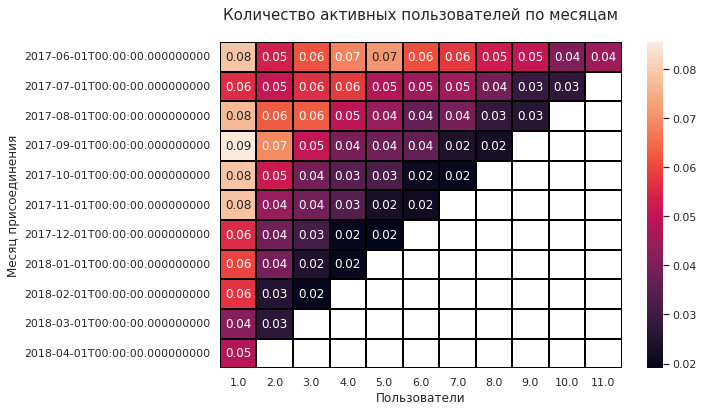

In [38]:
#строим retention в процентах
for i in retention.iloc[0:-1,1:].columns:
    retention[i]=retention[i]/retention[0]

plt.figure(figsize=(9, 6))
plt.title('retention_pivot')
sns.heatmap(retention.iloc[0:-1,1:], annot=True, fmt='.2f', linewidths=1, linecolor='black') 

plt.title("Количество активных пользователей по месяцам\n", fontsize=15)
plt.ylabel("Месяц присоединения")
plt.xlabel("Пользователи")
plt.show()

In [39]:
print("Средний Retention Rate на второй месяц «жизни» когорт", round(retention[2].mean(),2))

Средний Retention Rate на второй месяц «жизни» когорт 0.05


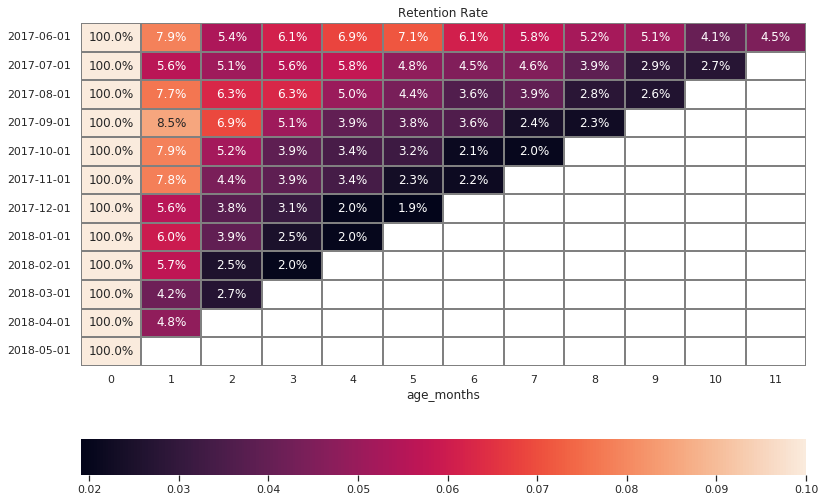

In [40]:
#создадим месяц сессии 
visits_copy['session_month'] = visits_copy['start_ts'].astype('datetime64[M]')


# Чтобы построить когортный отчет, нужно определить дату и время первой сессии каждого пользователя.
first_visits = visits_copy.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_visits.columns = ['uid', 'first_session_start_ts']
first_visits.head()

# для удобства группировки, добавим колонки даты и месяца
first_visits['first_session_dt'] = first_visits['first_session_start_ts'].dt.date
first_visits['first_session_month'] = first_visits['first_session_start_ts'].astype('datetime64[M]')

# добавляем информацию о первом визите в датафрейм с посетителями
for_retention = pd.merge(first_visits, visits_copy, on = 'uid')

# считаем, сколько прошло времени между каждой сессией и первой сессией пользователя
for_retention['age_months'] = ((for_retention['session_month'] - for_retention['first_session_month']) / np.timedelta64(1,'M')).round().astype('int')

# Когортный анализ по количеству посетителей.
cohorts = for_retention.pivot_table(index='first_session_month',
                  columns='age_months',
                  values='uid',
                  aggfunc='nunique')
cohorts.fillna('')

# Расчитаем Retention Rate
retention = pd.DataFrame()
for col in cohorts.columns:
    retention = pd.concat([retention, cohorts[col]/cohorts[0]], axis=1)
retention.columns = cohorts.columns
retention.index = [str(x)[0:10] for x in retention.index]
plt.figure(figsize=(13, 9))
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='grey',  vmax=0.1, cbar_kws= {'orientation': 'horizontal'} 
            ).set(title = 'Retention Rate')
plt.show()

### Метрики электронной коммерции
<a name="12."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [41]:
# определим временне промежутки
expenses['week'] = expenses['dt'].astype('datetime64[W]') 
expenses['month'] = expenses['dt'].astype('datetime64[M]') 
expenses['day'] = expenses['dt'].astype('datetime64[D]') 

#### Исследуйте, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. Изучать изменение этой метрики во времени необязательно;


In [42]:
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_order_date = orders.groupby(['uid'])['buy_ts'].min()
first_order_dated= pd.concat([first_order_date, first_activity_date], axis=1, join="inner")
first_order_dated['days_before_buying'] = (first_order_dated['buy_ts'] - first_order_dated['start_ts']) / np.timedelta64(1, 'D')


In [43]:
first_order_dated['days_before_buying'].describe()

count     36523.00
mean         16.90
std          47.07
min           0.00
25%           0.00
50%           0.01
75%           2.01
max         363.29
Name: days_before_buying, dtype: float64

min: 0.0 днейmax: 363.3 дней
mean: 16.9 дней median: 0.0 дней


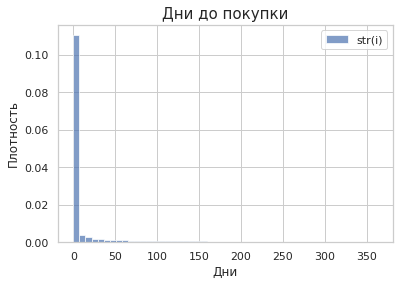

In [44]:
first_order_dated['days_before_buying'].hist(bins = 50, alpha=0.7, label = "str(i)",  density=True)
print("min:",round(min(first_order_dated['days_before_buying']),1),'дней'
      "max:",round(max(first_order_dated['days_before_buying']),1),'дней' )
print("mean:",round(first_order_dated['days_before_buying'].mean(),1),'дней'
      ,"median:",round(first_order_dated['days_before_buying'].median(),1),'дней' )
plt.xlabel("Дни")
plt.ylabel("Плотность")
plt.title("Дни до покупки", fontsize=15) 
plt.legend()
plt.show()

In [45]:
# почистим от экстремальных значений
mode_first_order = first_order_dated[(first_order_dated['days_before_buying'] >= 0)]
mode_first_order = mode_first_order[(mode_first_order['days_before_buying'] <  max(mode_first_order['days_before_buying'])
                           - (np.std(mode_first_order['days_before_buying'])*3))]

print("До покупки чаще всего проходит", round(mode_first_order['days_before_buying'].mode().values[0] * 24 * 60, 0), "минут")
print("Медианно требуется", round(mode_first_order['days_before_buying'].median() * 24 * 60 , 0) , "минут")



До покупки чаще всего проходит 1.0 минут
Медианно требуется 16.0 минут


Клиенты покупают услугу в первые минуты

#### Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. 

In [46]:
first_activity_date = first_activity_date.reset_index()
orders = orders.merge(first_activity_date,on='uid')

In [47]:
orders['first_activity_month'] = orders['start_ts'].astype('datetime64[M]') 

orders['week'] = orders['buy_ts'].astype('datetime64[W]') 
orders['month'] = orders['buy_ts'].astype('datetime64[M]') 
orders['day'] = orders['buy_ts'].astype('datetime64[D]') 

orders['cohort_lifetime'] = orders['month'] - orders['first_activity_month']
orders['cohort_lifetime'] = (orders['cohort_lifetime']/np.timedelta64(1,'M')).astype(int)


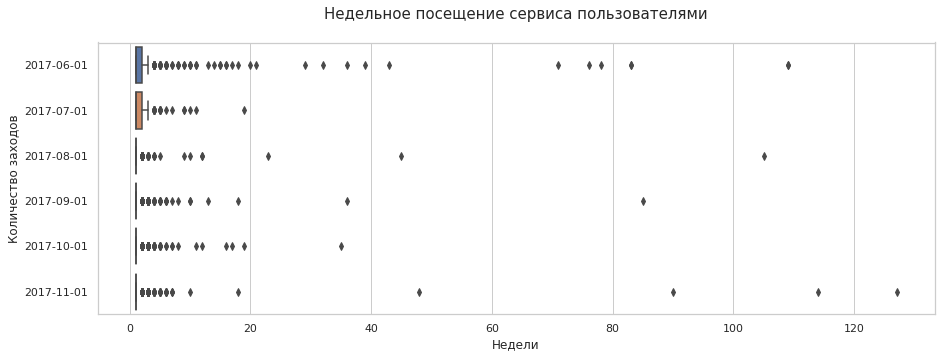

In [48]:
data = orders[orders['buy_ts'] > (max(orders['buy_ts'])  - np.timedelta64(6, 'M'))].pivot_table(index=['first_activity_month','uid']
                  , values = 'buy_ts',aggfunc='count').reset_index()

data = data[data['first_activity_month'] <= '2017-11-01']

data['first_activity_month'] = data['first_activity_month'].astype('str')
#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (15,5)) 
sns.boxplot(x="buy_ts", y="first_activity_month", data=data)

plt.title("Недельное посещение сервиса пользователями\n", fontsize=15)
plt.xlabel("Недели")
plt.ylabel("Количество заходов")
plt.show()

In [49]:
count_pay = orders[orders['buy_ts'] > (max(orders['buy_ts'])  - np.timedelta64(6, 'M')) ].groupby(['uid'])['buy_ts'].count()

print("В среднем оплата:", round(count_pay.mean(),2), "раз за 6 месяцев")



В среднем оплата: 1.34 раз за 6 месяцев


Более ранние кагорты за 6 месяцев покупали больше контента.
В среднем кагорты покупают 1.34 раз за 6 месяцев

#### Рассчитайте средний чек;



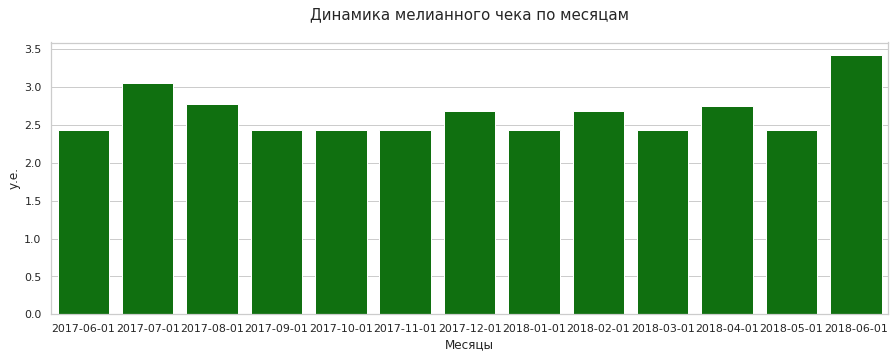

In [50]:
data = orders.groupby(['month']).agg({'revenue': 'median'}).reset_index()
data['month'] = data['month'].astype('str')
#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (15,5)) 
sns.barplot(y="revenue", x="month", data=data,
            label="Total" , color="green")
plt.title("Динамика мелианного чека по месяцам\n", fontsize=15)
plt.xlabel("Месяцы")
plt.ylabel("y.e.")
plt.show()

In [51]:
print("Медианный чек:", round(orders['revenue'].median(),2))

Медианный чек: 2.5


Размер медианного чека стабилен от месяца к месяцу и составляет 2.5 y.e.

#### Выясните, как меняется во времени LTV на покупателя по когортам. Помните, что LTV — накопительная метрика. Рассчитайте средний LTV по когортам за 6 месяцев; в расчёт включайте когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%.

In [52]:
# определим временне промежутки
orders['week'] = orders['buy_ts'].astype('datetime64[W]') 
orders['month'] = orders['buy_ts'].astype('datetime64[M]') 
orders['day'] = orders['buy_ts'].astype('datetime64[D]') 

In [53]:
first_orders = orders.groupby('uid').agg({'month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

In [54]:
cohort_sizes = (
    first_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']
display(cohort_sizes.head()) 

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [55]:
orders_new = pd.merge(orders,first_orders, on='uid')
cohorts = (
    orders_new.groupby(['first_order_month', 'month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [56]:
margin_rate = 1

report['gp'] = report['revenue'] * margin_rate
report['age'] = (
    report['month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
display(report.head()) 

,first_order_month,n_buyers,month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4


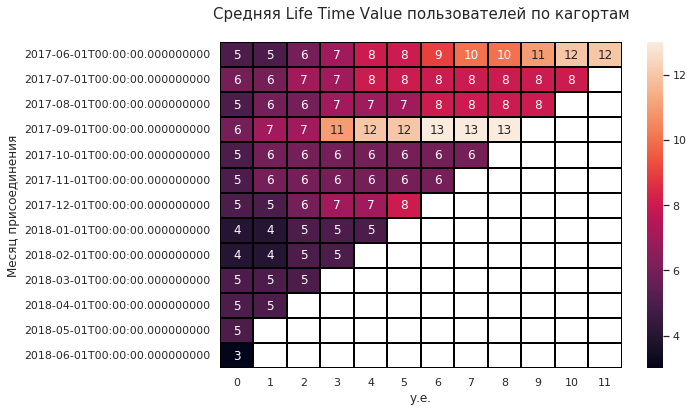

In [57]:
report['ltv'] = report['gp'] / report['n_buyers']

output = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
).cumsum(axis = 1).round()

plt.figure(figsize=(9, 6))
plt.title('output')
sns.heatmap(output, annot=True, fmt='.0f', linewidths=1, linecolor='black') 

plt.title("Средняя Life Time Value пользователей по кагортам\n", fontsize=15)
plt.ylabel("Месяц присоединения")
plt.xlabel("y.e.")
plt.show()


In [58]:
output_6_month = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').round().iloc[0:6,0:7]
output_6_month['LTV_6'] = output_6_month.T.sum()
output_6_month['LTV_6']

print("Средний LVL за 6 месяцев:", round(output_6_month['LTV_6'].mean(),2))


Средний LVL за 6 месяцев: 7.67


Наибольшая LTV за 6 месяцев у кагорты стартовавшей в сентябре, а наименьшие среди стартовавших в октябре и ноябре. 

Средний LVL за 6 месяцев по кагортам : 7.7

### Маркетинговые метрики
<a name="13."></a>
[<font size="2">(к содержанию)</font>](#1common.)

Посчитайте и отобразите на графиках, как маркетинговые метрики различаются по рекламным источникам.
Один и тот же пользователь мог заходить на сайт из нескольких источников, поэтому важно определить «главный» источник для каждого и учитывать это в расчётах. Например, главным может стать первый источник перехода.

In [59]:
# определим временне промежутки
expenses['week'] = expenses['dt'].astype('datetime64[W]') 
expenses['month'] = expenses['dt'].astype('datetime64[M]') 
expenses['day'] = expenses['dt'].astype('datetime64[D]') 

#### Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам;


In [60]:
total_expenses = expenses['costs'].sum()

print("Все затраты на маркетинг", round(total_expenses,0))

Все затраты на маркетинг 329132.0


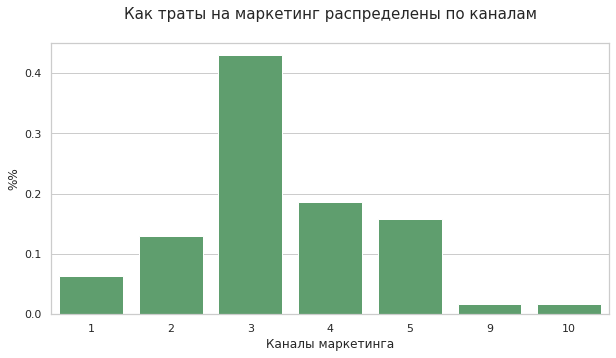

In [61]:
expenses_marketing = expenses.pivot_table(
    index='source_id', values='costs', aggfunc='sum'
).reset_index()
expenses_marketing['rate_expenses'] = expenses_marketing['costs'] / total_expenses

#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (10,5)) 
sns.barplot(y="rate_expenses", x="source_id", data=expenses_marketing,
            label="Total", color="g")
plt.title("Как траты на маркетинг распределены по каналам\n", fontsize=15)
plt.ylabel("%%")
plt.xlabel("Каналы маркетинга")
plt.show()

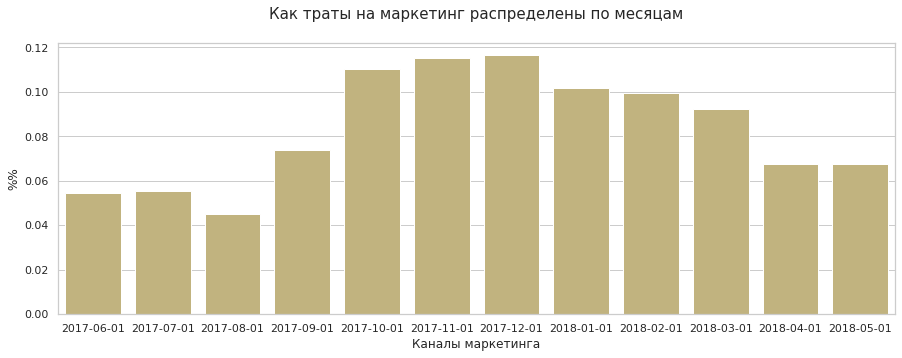

In [62]:
expenses_month = expenses.pivot_table(
    index='month', values='costs', aggfunc='sum'
).reset_index()
expenses_month['rate_expenses'] = expenses_month['costs'] / total_expenses
expenses_month['month'] = expenses_month['month'].astype('str')

#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (15,5)) 
sns.barplot(y="rate_expenses", x="month", data=expenses_month,
            label="Total", color="y")
plt.title("Как траты на маркетинг распределены по месяцам\n", fontsize=15)
plt.ylabel("%%")
plt.xlabel("Каналы маркетинга")
plt.show()

Больше всего трат на источник 3 (43%), меньше всего на источники 9 и 10 (по 2%).

В течении года затраты на маркетинг распределены не равномерно. Больше всего вкложений просиходит в осенне-зимнее время.

#### Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика;

In [63]:
# соединим данные Source Id с покупателями хотябы один раз 
buyer_source = first_order_dated.merge(visits, how= 'left' , on = ['uid', 'start_ts'])


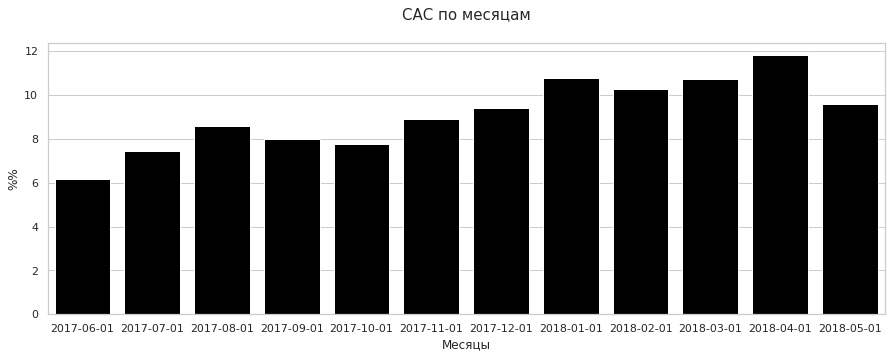

In [64]:
month_CAC = buyer_source.pivot_table(index='month', values='first_activity_month', aggfunc='count').reset_index()
month_CAC['month'] = month_CAC['month'].astype('str')
month_CAC = expenses_month.merge(month_CAC, on = 'month')
month_CAC['CAC'] = month_CAC['costs'] / month_CAC['first_activity_month']

#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (15,5)) 
sns.barplot(y="CAC", x="month", data=month_CAC,
            label="Total", color="black")
plt.title("CAC по месяцам\n", fontsize=15)
plt.ylabel("%%")
plt.xlabel("Месяцы")
plt.show()

In [65]:

total_CAC = total_expenses / len(buyer_source)
total_CAC
#9 единиц на одного покупателя

9.011626098622786

Общий показатель CAC равен 9 y.e. 
В течении года показател распределен относительно равномерно. Дороже всего завлечь клиентов в зимне-весенний период.

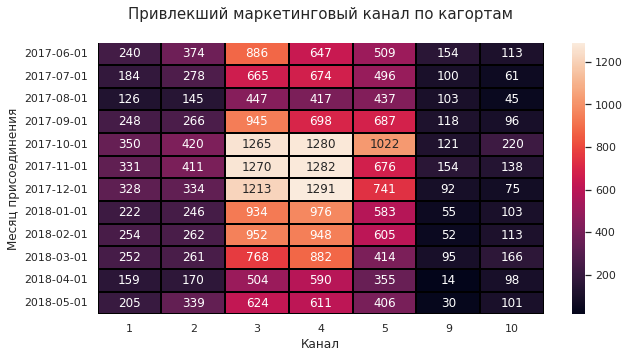

In [66]:
buyer_source_pivot = buyer_source.query('source_id != 7').pivot_table(
    index='first_activity_month', columns='source_id', values='uid', aggfunc='count'
).reset_index()

buyer_source_pivot['first_activity_month'] = buyer_source_pivot['first_activity_month'].astype('str')
buyer_source_pivot.index = buyer_source_pivot['first_activity_month']
buyer_source_pivot = buyer_source_pivot.iloc[:,1:]

plt.figure(figsize=(10, 5))
plt.title('buyer_source_pivot')
sns.heatmap(buyer_source_pivot, annot=True, fmt='.0f', linewidths=1, linecolor='black') 

plt.title("Привлекший маркетинговый канал по кагортам\n", fontsize=15)
plt.ylabel("Месяц присоединения")
plt.xlabel("Канал")
plt.show()


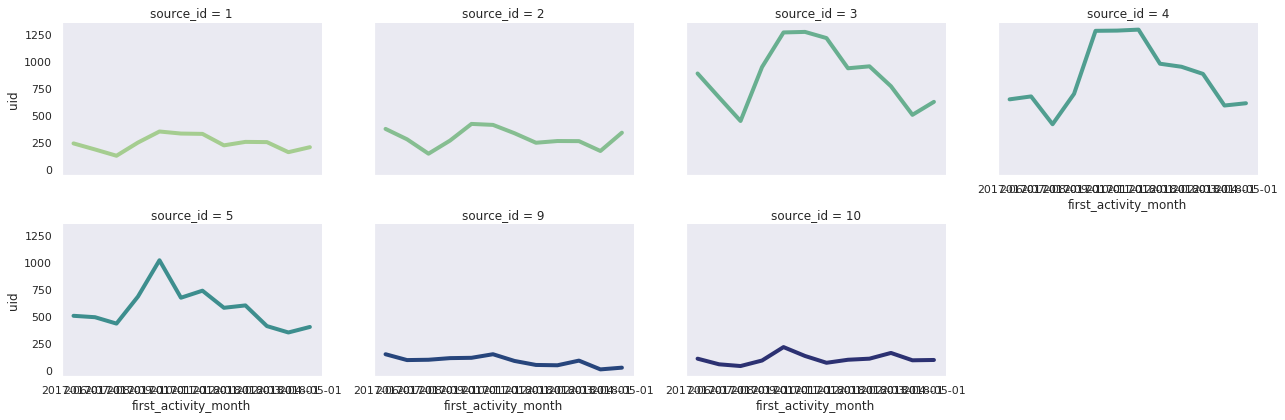

In [67]:
# посмотрим по другому

buyer_source_pivot = buyer_source.query('source_id != 7').pivot_table(
    index=['first_activity_month','source_id'],  values='uid', aggfunc='count'
).reset_index()

buyer_source_pivot['first_activity_month'] = buyer_source_pivot['first_activity_month'].astype('str')
sns.set_theme(style="dark")

# Plot each year's time series in its own facet
g = sns.relplot(
    data=buyer_source_pivot,
    y="uid", x="first_activity_month", col="source_id", hue="source_id",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=4, height=3, aspect=1.5, legend=False,
)

plt.show()

Самые привлекательные для пользователей маркетинговые каналы 3, 4, 5

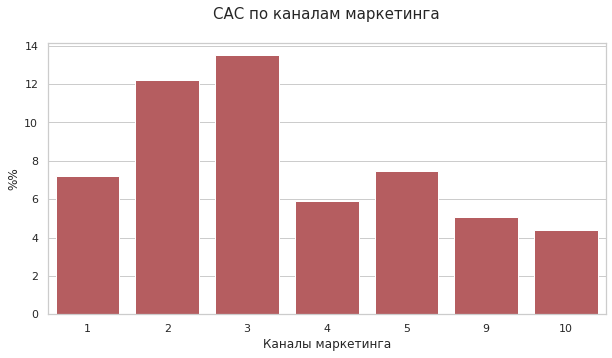

In [68]:
buyer_source_pivot = buyer_source.pivot_table(
    index='source_id', values='uid', aggfunc='count'
).reset_index()
buyer_source_pivot.columns = ['source_id', 'count_unique']
buyer_source_pivot = expenses_marketing.merge(buyer_source_pivot, how = 'left', on = 'source_id')
buyer_source_pivot['CAC'] = buyer_source_pivot['costs'] / buyer_source_pivot['count_unique']

#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (10,5)) 
sns.barplot(y="CAC", x="source_id", data=buyer_source_pivot,
            label="Total", color="r")
plt.title("CAC по каналам маркетинга\n", fontsize=15)
plt.ylabel("%%")
plt.xlabel("Каналы маркетинга")
plt.show()

Наибольший CAC у 2 и 3 канала

In [69]:
buyer_source_pivot_month = buyer_source.pivot_table(
    index=['month','source_id'], values='uid', aggfunc='count').reset_index()
buyer_source_pivot_month.columns = ['month','source_id', 'count_unique']

expenses_month_marketing = expenses.pivot_table(
    index=['month','source_id'], values='costs', aggfunc='sum').reset_index()

buyer_source_pivot_month = expenses_month_marketing.merge(buyer_source_pivot_month, how = 'left', on = ['month','source_id'])
buyer_source_pivot_month['CAC'] = buyer_source_pivot_month['costs'] / buyer_source_pivot_month['count_unique']

buyer_source_pivot_month['month']= buyer_source_pivot_month['month'].astype('str')
buyer_source_pivot_month['month'] = buyer_source_pivot_month['month'].str[2:7]

САС по каналам маркетинга по масяцам



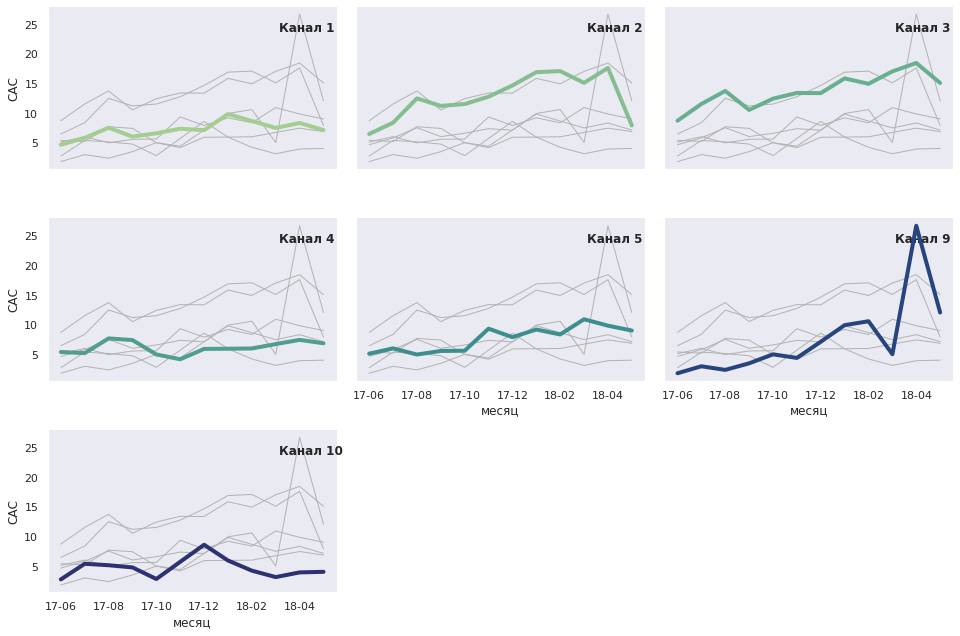

In [70]:
print("САС по каналам маркетинга по масяцам\n")
sns.set_theme(style="dark")

g = sns.relplot(
    data=buyer_source_pivot_month,
    y="CAC", x="month", col="source_id", hue="source_id",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=3, aspect=1.5, legend=False,
)

for source_id, ax in g.axes_dict.items():
    ax.text(.8, .85, "Канал "+str(source_id), transform=ax.transAxes, fontweight="bold")
    sns.lineplot(
        data=buyer_source_pivot_month, x="month", y="CAC", units="source_id",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

ax.set_xticks(ax.get_xticks()[::2])
g.set_titles("")
g.set_axis_labels("месяц", "CAC")
g.tight_layout()

In [71]:
expenses_copy

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


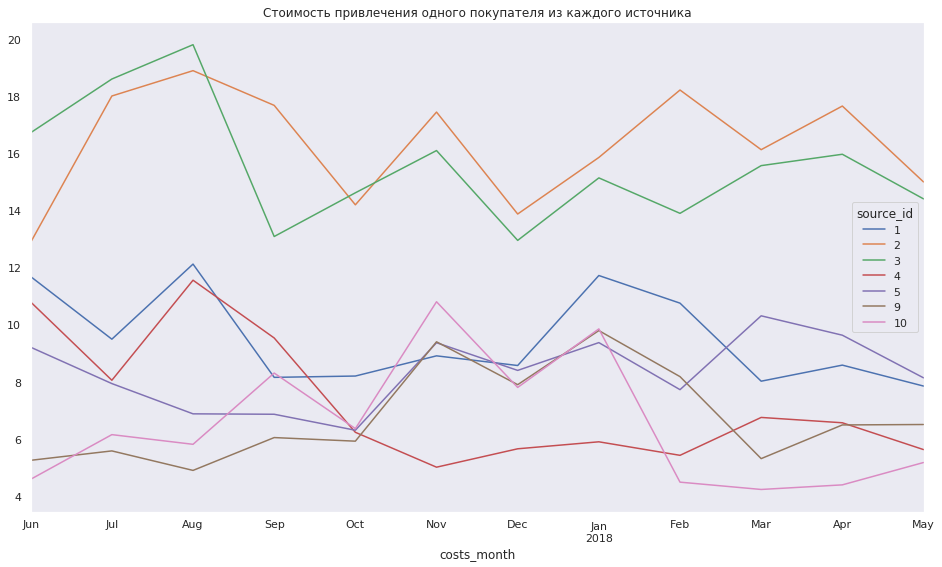

In [72]:
# Найдем время первой покупки каждого покупателя
first_orders = orders_copy.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_ts']
first_orders['first_order_dt'] = first_orders['first_order_ts'].dt.date
first_orders['first_order_month'] = first_orders['first_order_ts'].astype('datetime64[M]')

#отсортируем визиты по начальной дате и сгруппируем по первому uid.
sources = visits_copy.sort_values('start_ts').groupby('uid').first()
sources = sources[['source_id']]

#объединим
sources_orders = pd.merge(first_orders,sources, left_on='uid', right_index=True)

#объединим по источнику и дню
buyers_daily = sources_orders.groupby(['source_id', 'first_order_dt']).agg({'uid': 'count'}).reset_index()
buyers_daily.rename(columns={'uid': 'n_buyers'}, inplace=True)
buyers_daily['first_order_dt'] = pd.to_datetime(buyers_daily['first_order_dt'])

#добавим месяц в расходы
expenses_copy['costs_month'] = expenses_copy['dt'].astype('datetime64[M]')

#объединим таблицы и посчитаем
for_cac = pd.merge(buyers_daily, expenses_copy, left_on=['source_id', 'first_order_dt'], right_on=['source_id', 'dt'])
for_cac['costs_per_buyer'] = for_cac['costs']/for_cac['n_buyers']

for_cac.pivot_table(index=['costs_month'], columns='source_id', values='costs_per_buyer', aggfunc='mean').plot(
    figsize=(16,9), title='Стоимость привлечения одного покупателя из каждого источника')
plt.show()

#### Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт. Обратите внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV.

In [73]:

# Сделаем фцнкцию для удобства
def romi_6_source(i, margin_rate, fo):
    first_orders= fo.merge(buyer_source.loc[:,['uid','source_id']], on='uid')

    cohort_sizes = (
    first_orders[first_orders['source_id'] ==i]
    .groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
    )
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
    orders_first_month = pd.merge(orders, first_orders, on='uid')
    orders_first_month = orders_first_month[orders_first_month['source_id'] ==i]
    cohorts = (
    orders_first_month.groupby(['first_order_month', 'month'])
    .agg({'revenue': 'sum'})
    .reset_index()
    )
    
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
    report['gp'] = report['revenue'] * margin_rate
    report['age'] = (
        report['month'] - report['first_order_month']
    ) / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')
    report['ltv'] = report['gp'] / report['n_buyers']
    
    monthly_costs = expenses[expenses['source_id'] == i].groupby('month').sum()
    report_new = pd.merge(
        report, monthly_costs, left_on='first_order_month', right_on='month'
    )

    report_new['cac'] = report_new['costs'] / report_new['n_buyers']
    report_new['romi'] = report_new['ltv'] / report_new['cac']
    
    output_ltv = report_new.pivot_table(
        index='first_order_month', columns='age', values='ltv', aggfunc='mean'
    )
    output_6_month_ltv = output_ltv.iloc[0:6,0:7]
    output_6_month_ltv['ltv'] = output_6_month_ltv.T.sum()

    output = report_new.pivot_table(
        index='first_order_month', columns='age', values='romi', aggfunc='sum'
    )
    output_6_month = output.iloc[0:6,0:7]
    output_6_month['romi_6'] = output_6_month.T.sum()
    return output , output_6_month['romi_6'].mean(), cohort_sizes.iloc[0:6,:]['n_buyers'].mean(), output_6_month_ltv['ltv'].mean()

In [74]:
margin_rate = 1
i = 1

bases = {}

romi_6_m = pd.DataFrame()

for i in buyer_source['source_id'].unique():
    bases[i], romi_6_m.loc[i,'romi_6'], romi_6_m.loc[i,'cohort_sizes'] , romi_6_m.loc[i,'ltv_6']  = romi_6_source(i,margin_rate, first_orders)  
    

РОМИ по каналам маркетинга и кагортам



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Use the colorbar set_ticks() method instead.


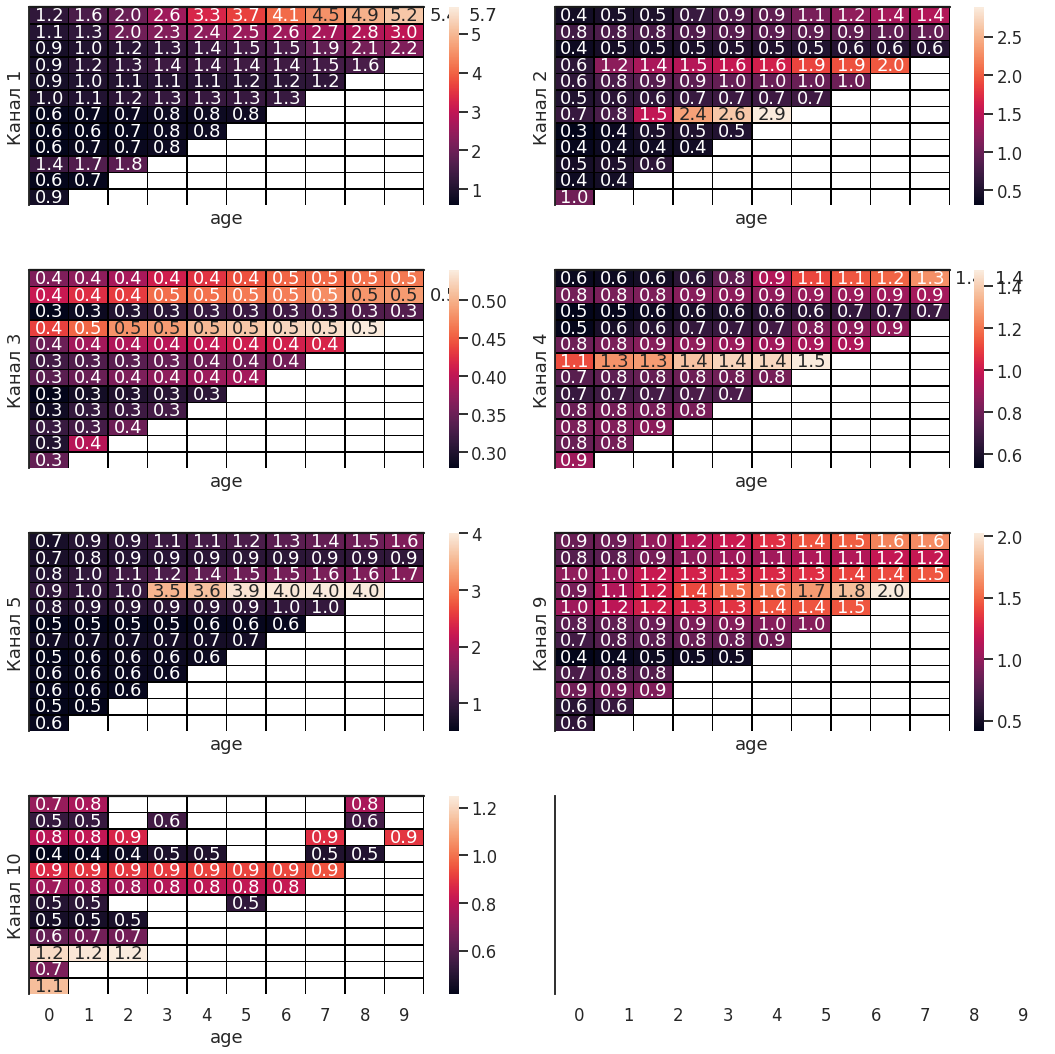

In [75]:
print("РОМИ по каналам маркетинга и кагортам\n")

sns.set_theme(style="white", context="talk")

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8))= plt.subplots(4, 2, figsize=(15, 15), sharex=True)

lst = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
lst_k = [1, 2, 3, 4, 5, 9, 10]

for i,n in zip(lst_k,lst):
    bases[i].index = bases[i].index.astype('str')
    sns.heatmap(bases[i].cumsum(axis = 1), annot=True, fmt='.1f', linewidths=0.5, linecolor='black',  ax=n)
    n.axhline(0, color="k", clip_on=False)
    n.set_ylabel("Канал "+ str(i))

sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)


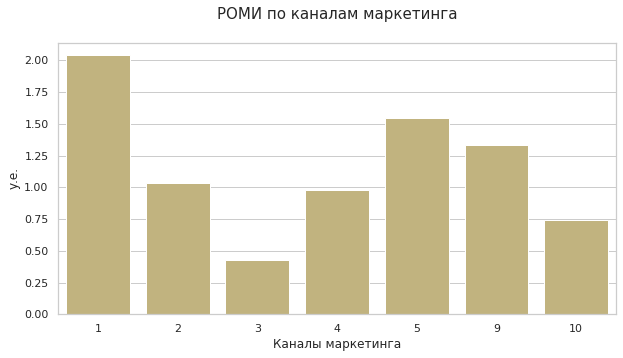

In [76]:
#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (10,5)) 
sns.barplot(y="romi_6", x="index", data=romi_6_m.dropna().reset_index(),
            label="Total", color="y")
plt.title("РОМИ по каналам маркетинга\n", fontsize=15)
plt.ylabel("y.e.")
plt.xlabel("Каналы маркетинга")
plt.show()

In [77]:
tmp = romi_6_m.query("cohort_sizes !=1").sort_values(by = 'cohort_sizes', ascending = False)
#tmp

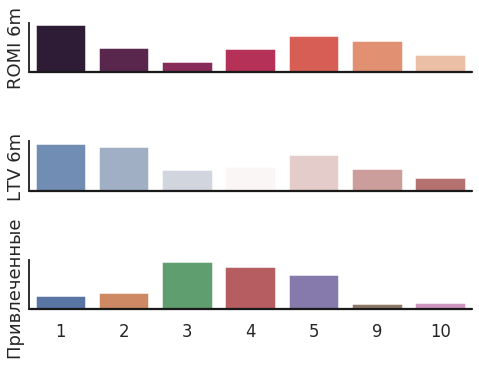

In [78]:
sns.set_theme(style="white", context="talk")

# Set up the matplotlib figure
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 5), sharex=True)

sns.barplot(x=tmp.index, y=tmp['romi_6'], palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("ROMI 6m")

sns.barplot(x=tmp.index, y=tmp['ltv_6'], palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("LTV 6m")

sns.barplot(x=tmp.index, y=tmp['cohort_sizes'], palette="deep", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Привлеченные ")


sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

Наиболее перспективными кажется 5 и 1 маркетинговые каналы. LTV ожидаемо коррелирует с ROMI

## Выводы и рекомендации
<a name="3."></a>
[<font size="2">(к содержанию)</font>](#1common.)


### Определите источники трафика, на которые маркетологам стоит делать упор. 

Наибольшее число посетителей приходят через 3, 4, 5 каналы ( с среднем 773, 701 и 566 соответвенно).

* Средняя окупаемость (РОМИ) на 6 месяцев в плюсе среди них только на канале 5. ***(Сейчас в него вкладывают 16% бюджетных средств) рекомендую увеличить данный процент.***


* На канале 4 метрика также с близка к окупаемости. ***Возможно рассмотреть продолжение инвестирования данного канала в текущем объеме***


* ***Сейчас затраты на канал 3 не приводят окупаемости даже половины вложений. Рекомендую снизить объем средств на этот канал.***


* ***Наиболее высокий РОМИ у канала 1, несмотря на относительно небольшой заход через него (в среднем 226 человек) стоит обратить на него внимание и попробовать расширить.*** Сейчас в него вкладывается только 6% маркетинговых средств.

### Опишите выводы, которые вы сделали после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции


* Ежедневно на сервисе активно 908 пользователей, эти пользователи в среднем заходят на сайт 1 раз в день.

* Продолжительность типичной пользовательской сессии 1 минута.

* Средний Retention Rate на второй месяц «жизни» когорт 5%

* Чаще всего покупка совершается в момент первого посещения сервиса. 
    * Покупают 1.34 раз за 6 месяцев
    * При этом средний (медианная) покупка составляет 2.5 у.е.
    
* Средний LVL за 6 месяцев: 7.67 у.е.

###  Подведите итоги когортного анализа. Определите самые перспективные для компании когорты клиентов

Так как первая покупка обычно происходит в момент первого посещения и ретеншен не очень высокий, то наиболее перспективными являются кагоры с наибольшим начальным стартовым числом.
* А именно это когорты стартовавшие в зимний период с октября по март месяцы.

Вероятно в этом есть наличие сезонности. Об этом также говорит повышенная рекламная активность в осенне-зимний период.
К началу следующего сезона нам также необходимо запланировать яркую рекламную активность.